In [1]:
# Import necissary packages

import math
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import datetime
from statsmodels import robust
import matplotlib as mpl
from matplotlib import gridspec
import turtle
from pytz import timezone

# Below are astropy functions

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

# Here are some packages to help find the Vmag

from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

# Found online.  Useful
def rows_uniq_elems(a):
    a_sorted = np.sort(a,axis=-1)
    return a[(a_sorted[...,1:] != a_sorted[...,:-1]).all(-1)]

In [2]:
# List contents of directory
dir_contents = np.array(os.listdir('/home/pj/UsbStick/Video/'))

# Only look at the video files
cond_video = [dir_contents[i][-4:]=='.avi' for i in np.arange(0,len(dir_contents))]
videos = dir_contents[cond_video]

# Check against completed lists
completed = pd.read_csv('all_videos_viewed.csv', index_col=0)
completed_vids = np.array(completed)[:,1]

# Now only have remaining videos
remaining_videos = np.array(list(set(videos)-set(completed_vids)))

In [3]:
# Create array of 2s
num = np.zeros((len(remaining_videos),))+2

# Specify path to videos
path_to_file1 = '/home/pj/UsbStick/Video/'

# Loop through videos to search for real events
for i in np.arange(0,len(remaining_videos)):
    
    # Run the mpv file and judge accordingly
    str_to_run = path_to_file1+remaining_videos[i]
    os.system('mpv '+str_to_run)
    print('Enter for false positive\nSpace for real')
    
    # Read output
    output = input(str(remaining_videos[i])+':  ')
    
    if output==' ':
        num[i] = 1
    else:
        num[i] = 0


In [ ]:
# If you stopped the code early, this bit removes all non-analyzed videos

cond = (num!=2)
num_cond = num[cond]
vid_cond = remaining_videos[cond]

# Column is the array of video names and the flag (1 for real, 0 for false)
column = np.column_stack((vid_cond,num_cond))

In [5]:
# This code reads the Obs Table to find the keycode for each video
# The resulting table shows (Video_code, Video_name, Flag)

obs_table = pd.read_csv('/home/pj/UsbStick/Obs_Table.csv')
obs_table = np.array(obs_table)[3:]

# Find datetimes for each video in obstable and our newly created table
vid_datetimes = [datetime.datetime.strptime(column[i,0],'%Y%m%d_%H%M%S.avi') for i in np.arange(0,len(column))]
obs_datetimes = [datetime.datetime.strptime(obs_table[i,2],'%Y%m%d %H:%M:%S') for i in np.arange(0,len(obs_table))]

# Create empty array with length equal to our newly created table
code = np.chararray((len(column)), itemsize=5)
code[:] = ''

# Loop through our newly created table
for i in np.arange(0,len(column)):
    w=0
    exact_time = vid_datetimes[i]
    
    # See if our video time is equal to one in ObsTable.  If so, append to emtpy array
    for j in np.arange(0,len(obs_datetimes)):
        if obs_datetimes[j]==exact_time:
            code[i] = obs_table[j,0]
            w = 1
            break
            
    # See if our video time is equal to one in ObsTable + 1 second.  If so, append to emtpy array
    if w==0:
        for j in np.arange(0,len(obs_datetimes)):
            if (obs_datetimes[j]+datetime.timedelta(0,1))==exact_time:
                code[i] = obs_table[j,0]
                w=1
                break
                
    # See if our video time is equal to one in ObsTable - 1 second.  If so, append to emtpy array
    if w==0:
        for j in np.arange(0,len(obs_datetimes)):
            if (obs_datetimes[j]-datetime.timedelta(0,1))==exact_time:
                code[i] = obs_table[j,0]
                w=1
                break
    # If it doesn't match anything in the ObsTable, we state the Video_code = fixme            
    if w==0:
        code[i] = 'fixme'
                

code = code.decode('utf-8')


# Stack together previous and current lists
stacked = pd.DataFrame(np.column_stack(((pd.DataFrame(code),pd.DataFrame(column)))))


In [ ]:
# If there are columns to append to all_videos_viewed, Do it!

if len(stacked)>0:
    with open('all_videos_viewed.csv', 'a') as f:
        stacked.to_csv(f, header=False)
        

# Now analyze real events

In [7]:
# Look at real events based on flag

data = pd.read_csv('all_videos_viewed.csv', usecols=[1,2,3])
good_ones = data.loc[lambda data: data['Real_flag'] == 1]
view_me = np.array(good_ones['Filename'])

In [8]:
# Specify path to videos
path_to_file1 = '/home/pj/UsbStick/Video/'

# For all real events, look at them
for i in np.arange(0,len(view_me)):
    str_to_run = path_to_file1+view_me[i]
    os.system('mpv '+str_to_run)
    

In [9]:
# Search for locations of fireballs

good_codes = np.array(good_ones['Code'])

fireball_locs = np.zeros((len(good_codes),2))
init_index = 0

for i in np.arange(0,len(obs_table)):
    if obs_table[i,0] in good_codes:
        fireball_locs[init_index] = obs_table[i,3],obs_table[i,4]
        init_index += 1
        
# Multiply locations by two to see where they really are
fireball_locs = fireball_locs*2

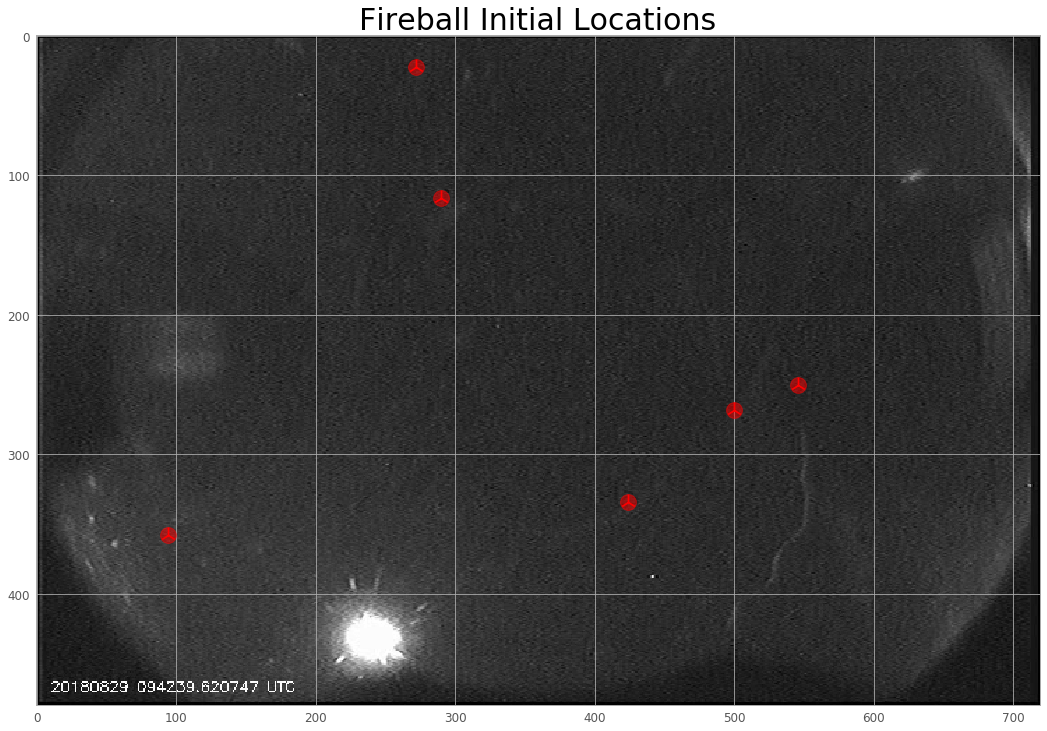

In [12]:
# Create backgroudn that is our camera
vid_name = view_me[4]
vid = cv2.VideoCapture(path_to_file1+vid_name)
vid.set(1,1)
ret, frame = vid.read()
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

# Make figure showing where fireballs have been found!
fig = plt.figure(figsize=(9*2,7*2))
plt.title('Fireball Initial Locations', fontsize=30)
plt.imshow(frame, cmap='gray')
plt.scatter(fireball_locs[:,0],fireball_locs[:,1], marker='o',
            s=50*5, color='r', alpha=0.5)
plt.scatter(fireball_locs[:,0],fireball_locs[:,1], marker='2',
            s=50*5, color='r')
plt.show()

# Optional Save
#fig.savefig('images/fireball_initlocs.png', bbox_inches='tight')

# Deleted Code

In [ ]:
########################################################################
# Trying to get image of fireball over time.  Failed attempt
########################################################################


#Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByInertia = False
params.filterByConvexity = False
# We want white things
params.filterByColor = True
params.blobColor = 255
# We want small things
params.filterByArea = True
params.maxArea = 100
params.minArea = 10
# We want fairly circular things
params.filterByCircularity = True
params.minCircularity = 0.1

# Set detector to look for specified parameters
detector = cv2.SimpleBlobDetector_create(params)

###################################################

for i in np.arange(len(view_me)-1,len(view_me)):
    vid_name = view_me[i]
    vid = cv2.VideoCapture(path_to_file1+vid_name)

    # Start at first frame
    vid.set(1,1)
    # Read video
    ret, frame = vid.read()
    # Convert to black and white
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Create Copy of first frame
    init = frame.copy()

    # Set initial large stack number
    stacksize = 10000

    frame = frame.astype(float)
    for i in range(stacksize):
        # Read in frame
        ret, newframe = vid.read()
        if not ret:
            # Find how many stacks are in the video and redefine it
            stacksize = i
            break
        # Make black and white but change to float to not run into int problem
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        # Add fractional average to stacked frame
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
        
    vid.set(1,1)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    init = frame.copy()

    frame = frame.astype(float)
    
    index = []
    for i in range(stacksize):
        ret, newframe = vid.read()
        if not ret:
            print('Something is wrong...')
        newframe = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY).astype(float)
        frame = cv2.add(frame, cv2.divide(newframe, stacksize))
        if i>0:
            newframe1 = cv2.absdiff(newframe,old)
            ret3,th31 = cv2.threshold(newframe1,45,255,cv2.THRESH_BINARY)
            th3 = th31.astype(np.uint8)
            keypoints = detector.detect(th3)
            x = [keypoints[j].pt[0] for j in np.arange(0,len(keypoints))]
            y = [keypoints[j].pt[1] for j in np.arange(
                0,len(keypoints))]
            locarray = np.column_stack((x,y))
            cond = locarray[:,1]<200
            locarray = locarray[cond]
            if len(locarray)>0:
                im_with_keypoints = cv2.drawKeypoints(th3, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                plt.imshow(im_with_keypoints)
                plt.show()
                index.append(i)
            
            
            
            
        old = np.zeros(newframe.shape)
        old[:] = newframe
    frame = cv2.convertScaleAbs(frame)
    #ret3,th3 = cv2.threshold(frame,140,255,cv2.THRESH_BINARY)

In [ ]:
# Continued attempt

empty = np.zeros(blah.shape)

for i in np.arange(0,len(index)):
    vid.set(1,int(index[i]))
    ret, frame = vid.read()
    # Convert to black and white
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    ret3,th31 = cv2.threshold(frame,45,255,cv2.THRESH_BINARY)
    empty = empty + th31
    plt.imshow(frame)
    plt.show()

In [ ]:
########################################################################
# Combining vids_4-14 with the Obs_table
########################################################################


column = pd.read_csv('vids_4-14.csv', index_col=0)
column = np.array(column)


obs_table = pd.read_csv('/home/pj/UsbStick/Obs_Table.csv')
obs_table = np.array(obs_table)[3:]
obs_table


vid_datetimes = [datetime.datetime.strptime(column[i,0],'%Y%m%d_%H%M%S.avi') for i in np.arange(0,len(column))]
obs_datetimes = [datetime.datetime.strptime(obs_table[i,2],'%Y%m%d %H:%M:%S') for i in np.arange(0,len(obs_table))]


code = np.chararray((len(column)), itemsize=5)
code[:] = ''

for i in np.arange(0,len(column)):
    w=0
    exact_time = vid_datetimes[i]
    for j in np.arange(0,len(obs_datetimes)):
        if obs_datetimes[j]==exact_time:
            code[i] = obs_table[j,0]
            w = 1
            break
    if w==0:
        for j in np.arange(0,len(obs_datetimes)):
            if (obs_datetimes[j]+datetime.timedelta(0,1))==exact_time:
                code[i] = obs_table[j,0]
                w=1
                break
    if w==0:
        for j in np.arange(0,len(obs_datetimes)):
            if (obs_datetimes[j]-datetime.timedelta(0,1))==exact_time:
                code[i] = obs_table[j,0]
                w=1
                break
    if w==0:
        code[i] = 'fixme'
                

code = code.decode('utf-8')


# Stack together previous and current lists
stacked = pd.DataFrame(np.column_stack(((pd.DataFrame(code),pd.DataFrame(column)))))
# Look at problem videos
np.array(stacked)[np.array(stacked)[:,0]=='']


stacked = pd.DataFrame(np.column_stack(((pd.DataFrame(code),pd.DataFrame(column)))))
completed = pd.read_csv('videos_checked.csv', index_col=0)

both = np.vstack((np.array(stacked),np.array(completed)))
both = pd.DataFrame(both)
both.columns = ['Code', 'Filename','Real_flag']


# Save to file
#both.to_csv('all_videos_viewed.csv')

In [ ]:
column = np.array([['20181117_050251.avi', '0.0'],
       ['20190126_123805.avi', '0.0'],
       ['20181020_031331.avi', '0.0'],
       ['20181117_041637.avi', '0.0'],
       ['20190126_130920.avi', '0.0'],
       ['20181117_050223.avi', '0.0'],
       ['20190126_131144.avi', '0.0'],
       ['20190126_131505.avi', '0.0'],
       ['20181207_090433.avi', '0.0'],
       ['20181117_041716.avi', '0.0'],
       ['20181117_050449.avi', '0.0'],
       ['20181117_043200.avi', '0.0'],
       ['20190126_131128.avi', '0.0'],
       ['20190126_122517.avi', '0.0'],
       ['20181117_050654.avi', '0.0'],
       ['20181020_041226.avi', '0.0'],
       ['20181117_041525.avi', '0.0'],
       ['20181117_034518.avi', '0.0'],
       ['20181117_041520.avi', '0.0'],
       ['20181117_043242.avi', '0.0'],
       ['20181117_041840.avi', '0.0'],
       ['20181022_104339.avi', '0.0'],
       ['20181119_020001.avi', '0.0'],
       ['20181117_050218.avi', '0.0'],
       ['20181117_041652.avi', '0.0'],
       ['20190126_054825.avi', '0.0'],
       ['20181117_045928.avi', '0.0'],
       ['20181117_050043.avi', '0.0'],
       ['20181117_041502.avi', '0.0'],
       ['20181022_115455.avi', '0.0'],
       ['20181020_031958.avi', '0.0'],
       ['20181117_041706.avi', '0.0'],
       ['20181206_043239.avi', '0.0'],
       ['20181117_041701.avi', '0.0'],
       ['20190126_131212.avi', '0.0'],
       ['20181020_031351.avi', '0.0'],
       ['20181118_021021.avi', '0.0'],
       ['20181117_050038.avi', '0.0'],
       ['20190126_054811.avi', '0.0'],
       ['20181206_021229.avi', '0.0'],
       ['20181117_041536.avi', '0.0'],
       ['20180819_054358.avi', '0.0'],
       ['20181117_050142.avi', '0.0'],
       ['20181117_041804.avi', '0.0'],
       ['20181117_050059.avi', '0.0'],
       ['20181117_041616.avi', '0.0'],
       ['20181020_030820.avi', '0.0'],
       ['20181117_050716.avi', '0.0'],
       ['20181117_050541.avi', '0.0'],
       ['20190126_131652.avi', '0.0'],
       ['20181119_031209.avi', '0.0'],
       ['20181117_050545.avi', '0.0'],
       ['20181021_032402.avi', '0.0'],
       ['20190126_122455.avi', '0.0'],
       ['20181117_050012.avi', '0.0'],
       ['20181117_050212.avi', '0.0'],
       ['20190126_131737.avi', '0.0'],
       ['20181020_030003.avi', '0.0'],
       ['20181117_034538.avi', '0.0'],
       ['20190126_054818.avi', '0.0'],
       ['20181020_032614.avi', '0.0'],
       ['20181206_043251.avi', '0.0'],
       ['20181020_030808.avi', '0.0'],
       ['20190126_131310.avi', '0.0'],
       ['20181117_050344.avi', '0.0'],
       ['20181022_111337.avi', '0.0'],
       ['20181020_031034.avi', '0.0'],
       ['20190126_131700.avi', '0.0'],
       ['20181020_045722.avi', '0.0'],
       ['20181117_050515.avi', '0.0'],
       ['20181023_102149.avi', '0.0'],
       ['20181023_101946.avi', '0.0'],
       ['20181020_033806.avi', '0.0'],
       ['20190126_131716.avi', '0.0'],
       ['20181022_112338.avi', '0.0'],
       ['20181117_043210.avi', '0.0'],
       ['20181020_034847.avi', '0.0'],
       ['20181117_041914.avi', '0.0'],
       ['20181117_045950.avi', '0.0'],
       ['20181205_030922.avi', '0.0'],
       ['20181117_041848.avi', '0.0'],
       ['20181117_045945.avi', '0.0'],
       ['20190126_131204.avi', '0.0'],
       ['20181117_050109.avi', '0.0'],
       ['20181117_041632.avi', '0.0'],
       ['20181117_050239.avi', '0.0'],
       ['20181023_102154.avi', '0.0'],
       ['20190126_131414.avi', '0.0'],
       ['20181117_043155.avi', '0.0'],
       ['20190126_122656.avi', '0.0'],
       ['20190126_131220.avi', '0.0'],
       ['20181205_030932.avi', '0.0'],
       ['20181022_114752.avi', '0.0'],
       ['20181117_043238.avi', '0.0'],
       ['20181117_050114.avi', '0.0'],
       ['20181117_050609.avi', '0.0'],
       ['20181117_041751.avi', '0.0'],
       ['20181117_043233.avi', '0.0'],
       ['20181119_104615.avi', '1.0'],
       ['20181206_021245.avi', '0.0'],
       ['20181019_030003.avi', '0.0'],
       ['20181117_041928.avi', '0.0'],
       ['20181117_041953.avi', '0.0'],
       ['20190126_131542.avi', '0.0'],
       ['20181020_033201.avi', '0.0'],
       ['20181117_050256.avi', '0.0'],
       ['20181020_034801.avi', '0.0'],
       ['20190126_122815.avi', '0.0'],
       ['20181117_050023.avi', '0.0'],
       ['20190126_131527.avi', '0.0'],
       ['20190126_054730.avi', '0.0'],
       ['20181117_052459.avi', '0.0'],
       ['20181117_050312.avi', '0.0'],
       ['20181117_050322.avi', '0.0'],
       ['20181117_050505.avi', '0.0'],
       ['20190126_131610.avi', '0.0'],
       ['20181020_033743.avi', '0.0'],
       ['20181117_050354.avi', '0.0'],
       ['20181117_050338.avi', '0.0'],
       ['20181023_114511.avi', '0.0'],
       ['20190126_131422.avi', '0.0'],
       ['20190126_131512.avi', '0.0'],
       ['20181117_050525.avi', '0.0'],
       ['20181020_031346.avi', '0.0'],
       ['20181117_043204.avi', '0.0'],
       ['20181117_050001.avi', '0.0'],
       ['20181117_050125.avi', '0.0'],
       ['20181020_031020.avi', '0.0'],
       ['20181118_033239.avi', '0.0'],
       ['20181117_050708.avi', '0.0'],
       ['20190126_131603.avi', '0.0'],
       ['20181021_032407.avi', '0.0'],
       ['20190126_131113.avi', '0.0'],
       ['20181117_041657.avi', '0.0'],
       ['20190126_131645.avi', '0.0'],
       ['20181020_031914.avi', '0.0'],
       ['20181117_050531.avi', '0.0'],
       ['20181117_050228.avi', '0.0'],
       ['20181117_050604.avi', '0.0'],
       ['20181117_050555.avi', '0.0'],
       ['20181206_022743.avi', '0.0'],
       ['20181117_050434.avi', '0.0'],
       ['20181117_050634.avi', '0.0'],
       ['20181117_045856.avi', '0.0'],
       ['20181117_041647.avi', '0.0'],
       ['20190126_122756.avi', '0.0'],
       ['20181117_041901.avi', '0.0'],
       ['20181117_041745.avi', '0.0'],
       ['20181117_041547.avi', '0.0'],
       ['20181117_041739.avi', '0.0'],
       ['20181117_041907.avi', '0.0'],
       ['20181022_030004.avi', '0.0'],
       ['20181117_050359.avi', '0.0'],
       ['20181022_115502.avi', '0.0'],
       ['20181117_041833.avi', '0.0'],
       ['20190126_123431.avi', '0.0'],
       ['20181020_045647.avi', '0.0'],
       ['20181023_102126.avi', '0.0'],
       ['20190126_131624.avi', '0.0'],
       ['20181117_041934.avi', '0.0'],
       ['20181117_041621.avi', '0.0'],
       ['20181117_050712.avi', '0.0'],
       ['20181020_034645.avi', '0.0'],
       ['20190126_131431.avi', '0.0'],
       ['20181117_050234.avi', '0.0'],
       ['20190126_123746.avi', '0.0'],
       ['20181023_110746.avi', '0.0'],
       ['20181117_050415.avi', '0.0'],
       ['20181117_050703.avi', '0.0'],
       ['20181020_031922.avi', '0.0'],
       ['20190126_131352.avi', '0.0'],
       ['20180819_050001.avi', '0.0'],
       ['20181020_045709.avi', '0.0'],
       ['20190126_131731.avi', '0.0'],
       ['20181118_055007.avi', '0.0'],
       ['20190126_122526.avi', '0.0'],
       ['20190126_030159.avi', '0.0'],
       ['20190126_131638.avi', '0.0'],
       ['20181205_055532.avi', '0.0'],
       ['20190126_131617.avi', '0.0'],
       ['20181117_043151.avi', '0.0'],
       ['20190126_030208.avi', '0.0'],
       ['20190126_131137.avi', '0.0'],
       ['20181022_115727.avi', '0.0'],
       ['20181117_050659.avi', '0.0'],
       ['20181022_115622.avi', '0.0'],
       ['20190126_131120.avi', '0.0'],
       ['20181023_102218.avi', '0.0'],
       ['20181117_043254.avi', '0.0'],
       ['20181117_050419.avi', '0.0'],
       ['20181117_050600.avi', '0.0'],
       ['20181117_041456.avi', '0.0'],
       ['20190126_123728.avi', '0.0'],
       ['20190126_131549.avi', '0.0'],
       ['20190126_131519.avi', '0.0'],
       ['20181020_030832.avi', '0.0'],
       ['20181023_102137.avi', '0.0'],
       ['20181022_061623.avi', '0.0'],
       ['20181117_041542.avi', '0.0'],
       ['20181117_041508.avi', '0.0'],
       ['20181023_102214.avi', '0.0'],
       ['20181117_041610.avi', '0.0'],
       ['20181117_034532.avi', '0.0'],
       ['20181023_102129.avi', '0.0'],
       ['20181117_041856.avi', '0.0'],
       ['20181023_102210.avi', '0.0'],
       ['20181117_050158.avi', '0.0'],
       ['20181023_042026.avi', '0.0'],
       ['20190126_130912.avi', '0.0'],
       ['20181117_050444.avi', '0.0'],
       ['20181020_034810.avi', '0.0'],
       ['20181117_050120.avi', '0.0'],
       ['20181206_025413.avi', '0.0'],
       ['20181022_102519.avi', '0.0'],
       ['20181019_115534.avi', '1.0'],
       ['20190126_131444.avi', '0.0'],
       ['20190126_123131.avi', '0.0'],
       ['20181117_043228.avi', '0.0'],
       ['20181022_111615.avi', '0.0'],
       ['20180819_092050.avi', '0.0'],
       ['20181117_050317.avi', '0.0'],
       ['20181117_041922.avi', '0.0'],
       ['20181020_034741.avi', '0.0'],
       ['20181117_041711.avi', '0.0'],
       ['20190126_123612.avi', '0.0'],
       ['20181023_040851.avi', '0.0'],
       ['20180819_053549.avi', '0.0'],
       ['20181117_050404.avi', '0.0'],
       ['20181117_045905.avi', '0.0'],
       ['20181117_041627.avi', '0.0'],
       ['20190126_131236.avi', '0.0'],
       ['20190126_131246.avi', '0.0'],
       ['20181117_050349.avi', '0.0'],
       ['20190126_131709.avi', '0.0'],
       ['20181020_034819.avi', '0.0'],
       ['20181022_111823.avi', '0.0'],
       ['20181117_050639.avi', '0.0'],
       ['20181117_050245.avi', '0.0'],
       ['20181117_050410.avi', '0.0'],
       ['20190126_131556.avi', '0.0'],
       ['20181020_035232.avi', '0.0'],
       ['20181205_030912.avi', '0.0'],
       ['20190126_050200.avi', '0.0'],
       ['20181020_035122.avi', '0.0'],
       ['20181117_050147.avi', '0.0'],
       ['20181117_041940.avi', '0.0'],
       ['20181119_124201.avi', '1.0'],
       ['20181117_050439.avi', '0.0'],
       ['20181117_043219.avi', '0.0'],
       ['20190126_131359.avi', '0.0'],
       ['20190126_131228.avi', '0.0'],
       ['20190126_122649.avi', '0.0'],
       ['20190126_131534.avi', '0.0'],
       ['20181117_050424.avi', '0.0'],
       ['20181023_095802.avi', '0.0'],
       ['20190126_131407.avi', '0.0'],
       ['20181117_041642.avi', '0.0'],
       ['20181020_031125.avi', '0.0'],
       ['20181117_041733.avi', '0.0'],
       ['20181118_021044.avi', '0.0'],
       ['20181117_034502.avi', '0.0'],
       ['20181117_050152.avi', '0.0'],
       ['20181117_050644.avi', '0.0'],
       ['20181117_045923.avi', '0.0'],
       ['20190126_123816.avi', '0.0'],
       ['20181118_102202.avi', '1.0'],
       ['20181117_050536.avi', '0.0'],
       ['20181205_110532.avi', '0.0'],
       ['20181022_102916.avi', '0.0'],
       ['20181117_045939.avi', '0.0'],
       ['20190126_122624.avi', '0.0'],
       ['20181023_040550.avi', '0.0'],
       ['20190126_123438.avi', '0.0'],
       ['20181020_030803.avi', '0.0'],
       ['20181117_050053.avi', '0.0'],
       ['20190126_131345.avi', '0.0'],
       ['20181117_050207.avi', '0.0'],
       ['20181117_050649.avi', '0.0'],
       ['20181117_043251.avi', '0.0'],
       ['20190126_122509.avi', '0.0'],
       ['20180925_111233.avi', '0.0'],
       ['20181117_050048.avi', '0.0'],
       ['20181117_050131.avi', '0.0'],
       ['20181023_102201.avi', '0.0'],
       ['20180819_050726.avi', '0.0'],
       ['20181117_045934.avi', '0.0'],
       ['20190126_123737.avi', '0.0'],
       ['20181117_050510.avi', '0.0'],
       ['20181020_034108.avi', '0.0'],
       ['20190126_130851.avi', '0.0'],
       ['20190126_123014.avi', '0.0'],
       ['20190126_130905.avi', '0.0'],
       ['20181117_045911.avi', '0.0'],
       ['20181117_050619.avi', '0.0'],
       ['20181117_041721.avi', '0.0'],
       ['20181117_050017.avi', '0.0'],
       ['20190126_131745.avi', '0.0'],
       ['20181117_050033.avi', '0.0'],
       ['20181117_050629.avi', '0.0'],
       ['20190126_122444.avi', '0.0'],
       ['20180819_053406.avi', '0.0'],
       ['20181117_045917.avi', '0.0'],
       ['20181117_050333.avi', '0.0'],
       ['20180819_092151.avi', '0.0'],
       ['20181117_050624.avi', '0.0'],
       ['20181117_041947.avi', '0.0'],
       ['20181117_050302.avi', '0.0'],
       ['20181020_045652.avi', '0.0'],
       ['20181117_050520.avi', '0.0'],
       ['20181117_050429.avi', '0.0'],
       ['20190126_131326.avi', '0.0'],
       ['20190126_122806.avi', '0.0'],
       ['20181022_103010.avi', '0.0'],
       ['20181117_041559.avi', '0.0'],
       ['20181117_041514.avi', '0.0'],
       ['20181117_050006.avi', '0.0'],
       ['20181020_034814.avi', '0.0'],
       ['20181118_021034.avi', '0.0'],
       ['20190126_122533.avi', '0.0'],
       ['20181117_041811.avi', '0.0'],
       ['20181022_115743.avi', '0.0'],
       ['20180819_094356.avi', '0.0'],
       ['20190126_123618.avi', '0.0'],
       ['20190126_122540.avi', '0.0'],
       ['20181023_102206.avi', '0.0'],
       ['20190126_131302.avi', '0.0'],
       ['20181117_050454.avi', '0.0'],
       ['20181205_051755.avi', '0.0'],
       ['20180819_101841.avi', '0.0'],
       ['20190126_130857.avi', '0.0'],
       ['20190126_131724.avi', '0.0'],
       ['20181117_045955.avi', '0.0'],
       ['20190126_131156.avi', '0.0'],
       ['20181022_114652.avi', '0.0'],
       ['20181022_104940.avi', '0.0'],
       ['20181117_043214.avi', '0.0'],
       ['20181117_041758.avi', '0.0'],
       ['20190126_131631.avi', '0.0'],
       ['20181023_102414.avi', '0.0'],
       ['20181021_030004.avi', '0.0'],
       ['20181117_050614.avi', '0.0'],
       ['20181022_112058.avi', '0.0'],
       ['20181117_050203.avi', '0.0'],
       ['20181117_041553.avi', '0.0'],
       ['20181117_041605.avi', '0.0'],
       ['20190126_054509.avi', '0.0'],
       ['20181117_041727.avi', '0.0'],
       ['20181117_043148.avi', '0.0'],
       ['20181117_050104.avi', '0.0'],
       ['20181117_050307.avi', '0.0'],
       ['20181117_050550.avi', '0.0'],
       ['20190126_123023.avi', '0.0'],
       ['20181117_041959.avi', '0.0'],
       ['20181117_043224.avi', '0.0'],
       ['20181020_035826.avi', '0.0'],
       ['20181117_043247.avi', '0.0'],
       ['20181023_040607.avi', '0.0'],
       ['20181022_113414.avi', '0.0'],
       ['20181020_045826.avi', '0.0'],
       ['20181117_041818.avi', '0.0'],
       ['20181117_050028.avi', '0.0'],
       ['20181023_102224.avi', '0.0'],
       ['20181020_033754.avi', '0.0'],
       ['20181117_041531.avi', '0.0'],
       ['20181117_050328.avi', '0.0'],
       ['20190126_131254.avi', '0.0'],
       ['20181206_024002.avi', '0.0'],
       ['20181023_030004.avi', '0.0'],
       ['20181117_045900.avi', '0.0'],
       ['20181020_034830.avi', '0.0'],
       ['20181206_021238.avi', '0.0'],
       ['20181022_111718.avi', '0.0'],
       ['20190126_123825.avi', '0.0'],
       ['20181020_035308.avi', '0.0'],
       ['20181117_050136.avi', '0.0'],
       ['20181117_050459.avi', '0.0']], dtype='<U32')